# Read in Data

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost

from sklearn import metrics,preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple

In [3]:
train_data = pd.read_csv("../input/train_v2.csv")
test_data = pd.read_csv("../input/test_v2.csv")

In [4]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


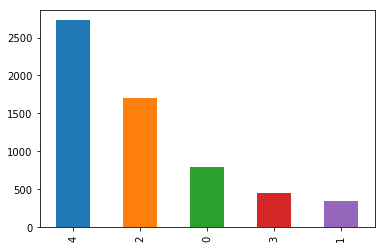

In [5]:
train_data.category.value_counts().plot(kind='bar')

# Housekeeping

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_data["title"], train_data["category"], test_size = 0.2)
X_train = np.array(X_train)
X_valid = np.array(X_valid)
Y_train = np.array(Y_train)
Y_valid = np.array(Y_valid)

In [7]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, label_valid)

In [8]:
# le_hostname = preprocessing.LabelEncoder()
# le_hostname.fit_transform(train_data['hostname']).shape

# le_publisher = preprocessing.LabelEncoder()
# le_publisher.fit_transform(train_data['publisher'].fillna('UNKNOWN'))

# Word Embedding

In [9]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing
from sklearn import utils

In [10]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

In [11]:
from random import shuffle

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

In [13]:
def read_corpus(x=None, y=None, unique_tags=False):
    if unique_tags:
        i = 1000  # just an offset
        for record in x:
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(record), [i])
            i += 1
    else:
        for record, label in zip(x, y):
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(record), [label])

In [14]:
# X_all = np.concatenate([X_train, X_valid])
# Y_all = np.concatenate([Y_train, Y_valid])
# all_corpus = list(read_corpus(X_all, Y_all))
# train_corpus = all_corpus[:len(X_train)]
# valid_corpus = all_corpus[len(X_train):]
# The above approach is incorrect

train_corpus = list(read_corpus(x=X_train, y=Y_train, unique_tags=False))
valid_corpus = list(read_corpus(x=X_valid, y=None, unique_tags=True))

In [15]:
train_corpus[-1]

TaggedDocument(words=['update', 'icahn', 'changes', 'course', 'urges', 'ebay', 'to', 'sell', 'pct', 'of', 'paypal'], tags=[4])

In [16]:
valid_corpus[-1]

TaggedDocument(words=['get', 'those', 'pencils', 'out', 'it', 'ncaa', 'bracket', 'time'], tags=[2205])

In [76]:
EPOCHS = 40
# PV-DBOW plain
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample=0, 
        epochs=EPOCHS, workers=cores)

# PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
model_dmm = Doc2Vec(dm=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, sample=0, 
        epochs=EPOCHS, workers=cores, alpha=0.05, comment='alpha=0.05')

# PV-DM w/ concatenation - big, slow, experimental mode
# window=5 (both sides) approximates paper's apparent 10-word total window size
model_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, sample=0, 
        epochs=EPOCHS, workers=cores)

for model in [model_dbow, model_dmm, model_dmc]:
    model.build_vocab(train_corpus)
    
model_dbow_dmm = ConcatenatedDoc2Vec([model_dbow, model_dmm])
model_dbow_dmc = ConcatenatedDoc2Vec([model_dbow, model_dmc])

In [77]:
def vec_for_learning(model, sents, reinfer=True, epochs=EPOCHS):
    if reinfer:
        vecs = [model.infer_vector(doc.words, epochs=epochs) for doc in sents]
    else:
        vecs = [model.docvecs[doc.tags[0]] for doc in sents]
    
    return vecs

In [78]:
%%time

reinfer=True  # should always be Ture in our case

doc_list = train_corpus[:]
shuffle(doc_list)

for model in [model_dbow, model_dmm, model_dmc, model_dbow_dmm, model_dbow_dmc]:
    model.train(doc_list, total_examples=len(doc_list), epochs=model.epochs)
    _X_train = vec_for_learning(model, train_corpus, reinfer=reinfer)
    _X_valid = vec_for_learning(model, valid_corpus, reinfer=reinfer)
    # clf = LogisticRegression()
    # clf = KNeighborsClassifier(n_neighbors=1)
    clf = SVC()  # 0.6633
    # clf = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
    # clf = RandomForestClassifier(n_estimators=180, criterion='gini')
    accuracy = train_model(clf, _X_train, Y_train, _X_valid, Y_valid)  # 0.6625
    print(accuracy)
    break

0.6666666666666666
CPU times: user 12.6 s, sys: 1 s, total: 13.6 s
Wall time: 11.5 s


# Create Submission Using Different Mothods

In [93]:
alltrain_corpus = list(read_corpus(x=train_data["title"], y=train_data["category"], unique_tags=False))

In [94]:
test_corpus = list(read_corpus(x=test_data["title"], unique_tags=True))

In [110]:
EPOCHS = 50
# PV-DBOW plain
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample=0, 
        epochs=EPOCHS, workers=cores)

# PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
model_dmm = Doc2Vec(dm=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, sample=0, 
        epochs=EPOCHS, workers=cores, alpha=0.05, comment='alpha=0.05')

# PV-DM w/ concatenation - big, slow, experimental mode
# window=5 (both sides) approximates paper's apparent 10-word total window size
model_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, sample=0, 
        epochs=EPOCHS, workers=cores)

for model in [model_dbow, model_dmm, model_dmc]:
    model.build_vocab(train_corpus)
    
model_dbow_dmm = ConcatenatedDoc2Vec([model_dbow, model_dmm])
model_dbow_dmc = ConcatenatedDoc2Vec([model_dbow, model_dmc])

In [111]:
def vec_for_learning(model, sents, reinfer=True, epochs=EPOCHS):
    if reinfer:
        vecs = [model.infer_vector(doc.words, epochs=epochs) for doc in sents]
    else:
        vecs = [model.docvecs[doc.tags[0]] for doc in sents]
    
    return vecs

In [112]:
%%time

reinfer=True  # should always be Ture in our case

doc_list = alltrain_corpus[:]
shuffle(doc_list)

for model in [model_dbow, model_dmm, model_dmc, model_dbow_dmm, model_dbow_dmc]:
    model.train(doc_list, total_examples=len(doc_list), epochs=model.epochs)
    _X_train = vec_for_learning(model, alltrain_corpus, reinfer=reinfer)
    # clf = SVC()
    clf = KNeighborsClassifier(n_neighbors=5)
    
    accuracy = train_model(clf, _X_train, train_data["category"], _X_train, train_data["category"])
    print(accuracy)
    break

0.8110170897627343
CPU times: user 15.7 s, sys: 1.53 s, total: 17.2 s
Wall time: 13.9 s


In [113]:
_X_test = vec_for_learning(model, test_corpus, reinfer=reinfer)
test_data["category"] = clf.predict(_X_test)

In [114]:
out=pd.DataFrame(test_data,columns=['article_id','category'])
out.to_csv('prediction.csv',index=False)